# Probability

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

The foundation of Bayesian statistics is Bayes's Theorem, and the foundation of Bayes's Theorem is conditional probability.  

In this chapter, we'll start with conditional probability, derive Bayes's Theorem, and demonstrate it using a real dataset.  In the next chapter, we'll use Bayes's Theorem to solve problems related to conditional probability.  In the chapters that follow, we'll make the transition from Bayes's Theorem to Bayesian statistics, and I'll explain the difference.

## Linda the Banker

To introduce conditional probability, I'll use an example from a [famous experiment by Tversky and Kahneman](https://en.wikipedia.org/wiki/Conjunction_fallacy), who posed the following question:

> Linda is 31 years old, single, outspoken, and very bright. She majored in philosophy. As a student, she was deeply concerned with issues of discrimination and social justice, and also participated in anti-nuclear demonstrations.  Which is more probable?
> 1. Linda is a bank teller.
> 2. Linda is a bank teller and is active in the feminist movement.

Many people choose the second answer, presumably because it seems more consistent with the description.  It seems uncharacteristic if Linda is *just* a bank teller; it seems more consistent if she is also a feminist.

But the second answer cannot be "more probable", as the question asks.  Suppose we find 1000 people who fit Linda's description and 10 of them work as bank tellers.  How many of them are also feminists?  At most, all 10 of them are; in that case, the two options are *equally* probable.  If fewer than 10 are, the second option is *less* probable.  But there is no way the second option can be *more* probable.

If you were inclined to choose the second option, you are in good company.  The biologist [Stephen J. Gould wrote](https://doi.org/10.1080/09332480.1989.10554932) :

> I am particularly fond of this example because I know that the [second] statement is least probable, yet a little [homunculus](https://en.wikipedia.org/wiki/Homunculus_argument) in my head continues to jump up and down, shouting at me, "but she can't just be a bank teller; read the description."

If the little person in your head is still unhappy, maybe this chapter will help.

## Probability

At this point I should provide a definition of "probability", but that [turns out to be surprisingly difficult](https://en.wikipedia.org/wiki/Probability_interpretations).  To avoid getting stuck before we start, we will use a simple definition for now and refine it later: A **probability** is a fraction of a finite set.

For example, if we survey 1000 people, and 20 of them are bank tellers, the fraction that work as bank tellers is 0.02 or 2\%.  If we choose a person from this population at random, the probability that they are a bank teller is 2\%.
By "at random" I mean that every person in the dataset has the same chance of being chosen.

With this definition and an appropriate dataset, we can compute probabilities by counting.
To demonstrate, I'll use data from the [General Social Survey](http://gss.norc.org/) (GSS).  

The following cell downloads the data.

In [1]:
# Load the data file

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/gss_bayes.csv')

Downloaded gss_bayes.csv


I'll use Pandas to read the data and store it in a `DataFrame`.

In [2]:
import pandas as pd

gss = pd.read_csv('gss_bayes.csv', index_col=0)
gss.head()

,year,age,sex,polviews,partyid,indus10
caseid,,,,,,
1,1974,21.0,1,4.0,2.0,4970.0
2,1974,41.0,1,5.0,0.0,9160.0
5,1974,58.0,2,6.0,1.0,2670.0
6,1974,30.0,1,5.0,4.0,6870.0
7,1974,48.0,1,5.0,4.0,7860.0


The `DataFrame` has one row for each person surveyed and one column for each variable I selected.

The columns are

* `caseid`: Respondent id (which is the index of the table).

* `year`: Year when the respondent was surveyed.

* `age`: Respondent's age when surveyed.

* `sex`: Male or female.

* `polviews`: Political views on a range from liberal to conservative.

* `partyid`: Political party affiliation, Democrat, Independent, or Republican.

* `indus10`: [Code](https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2007) for the industry the respondent works in.

Let's look at these variables in more detail, starting with `indus10`.

## Fraction of Bankers

The code for "Banking and related activities" is 6870, so we can select bankers like this:

In [4]:
banker = (gss['indus10'] == 6870)
banker.head()

caseid
1    False
2    False
5    False
6     True
7    False
Name: indus10, dtype: bool

The result is a Pandas `Series` that contains the Boolean values `True` and `False`.

If we use the `sum` function on this `Series`, it treats `True` as 1 and `False` as 0, so the total is the number of bankers.

In [5]:
banker.sum()

728

In this dataset, there are 728 bankers.

To compute the *fraction* of bankers, we can use the `mean` function, which computes the fraction of `True` values in the `Series`:

In [6]:
banker.mean()

0.014769730168391155

About 1.5% of the respondents work in banking, so if we choose a random person from the dataset, the probability they are a banker is about 1.5%.

## The Probability Function

I'll put the code from the previous section in a function that takes a Boolean series and returns a probability:

In [7]:
def prob(A):
    """Computes the probability of a proposition, A."""    
    return A.mean()

So we can compute the fraction of bankers like this:

In [43]:
prob(banker)

0.014769730168391155

Now let's look at another variable in this dataset.
The values of the column `sex` are encoded like this:

```
1    Male
2    Female
```

So we can make a Boolean series that is `True` for female respondents and `False` otherwise.

In [8]:
female = (gss['sex'] == 2)

In [9]:
female.head()

caseid
1    False
2    False
5     True
6    False
7    False
Name: sex, dtype: bool

And use it to compute the fraction of respondents who are women.

In [10]:
prob(female)

0.5378575776019476

The fraction of women in this dataset is higher than in the adult U.S. population because [the GSS does not include people living in institutions](https://gss.norc.org/faq) like prisons and military housing, and those populations are more likely to be male.

## Political Views and Parties

The other variables we'll consider are `polviews`, which describes the political views of the respondents, and `partyid`, which describes their affiliation with a political party.

The values of `polviews` are on a seven-point scale:

```
1	Extremely liberal
2	Liberal
3	Slightly liberal
4	Moderate
5	Slightly conservative
6	Conservative
7	Extremely conservative
```

I'll define `liberal` to be `True` for anyone whose response is "Extremely liberal", "Liberal", or "Slightly liberal".

In [11]:
liberal = (gss['polviews'] <= 3)

Here's the fraction of respondents who are liberal by this definition.

In [12]:
prob(liberal)

0.27374721038750255

If we choose a random person in this dataset, the probability they are liberal is about 27%.

The values of `partyid` are encoded like this:

```
0	Strong democrat
1	Not strong democrat
2	Independent, near democrat
3	Independent
4	Independent, near republican
5	Not strong republican
6	Strong republican
7	Other party
```

I'll define `democrat` to include respondents who chose "Strong democrat" or "Not strong democrat":

In [13]:
democrat = (gss['partyid'] <= 1)

And here's the fraction of respondents who are Democrats, by this definition.

In [14]:
prob(democrat)

0.3662609048488537

## Conjunction

Now that we have a definition of probability and a function that computes it, let's move on to conjunction.

"Conjunction" is another name for the logical `and` operation.  If you have two [propositions](https://en.wikipedia.org/wiki/Proposition), `A` and `B`, the conjunction `A and B` is `True` if both `A` and `B` are `True`, and `False` otherwise.

If we have two Boolean series, we can use the `&` operator to compute their conjunction.
For example, we have already computed the probability that a respondent is a banker.

In [15]:
prob(banker)

0.014769730168391155

And the probability that they are a Democrat:

In [16]:
prob(democrat)

0.3662609048488537

Now we can compute the probability that a respondent is a banker *and* a Democrat:

In [17]:
prob(banker & democrat)

0.004686548995739501

As we should expect, `prob(banker & democrat)` is less than `prob(banker)`, because not all bankers are Democrats.

We expect conjunction to be commutative; that is, `A & B` should be the same as `B & A`.  To check, we can also compute `prob(democrat & banker)`:

In [18]:
prob(democrat & banker)

0.004686548995739501

As expected, they are the same.

## Conditional Probability

Conditional probability is a probability that depends on a condition, but that might not be the most helpful definition.  Here are some examples:

* What is the probability that a respondent is a Democrat, given that they are liberal?

* What is the probability that a respondent is female, given that they are a banker?

* What is the probability that a respondent is liberal, given that they are female?

Let's start with the first one, which we can interpret like this: "Of all the respondents who are liberal, what fraction are Democrats?"

We can compute this probability in two steps:

1. Select all respondents who are liberal.

2. Compute the fraction of the selected respondents who are Democrats.

To select liberal respondents, we can use the bracket operator, `[]`, like this:

In [21]:
democrat.info()

<class 'pandas.core.series.Series'>
Index: 49290 entries, 1 to 2867
Series name: partyid
Non-Null Count  Dtype
--------------  -----
49290 non-null  bool 
dtypes: bool(1)
memory usage: 433.2 KB


In [22]:
liberal.info()

<class 'pandas.core.series.Series'>
Index: 49290 entries, 1 to 2867
Series name: polviews
Non-Null Count  Dtype
--------------  -----
49290 non-null  bool 
dtypes: bool(1)
memory usage: 433.2 KB


In [19]:
selected = democrat[liberal]

`selected` contains the values of `democrat` for liberal respondents, so `prob(selected)` is the fraction of liberals who are Democrats:

In [23]:
prob(selected)

0.5206403320240125

A little more than half of liberals are Democrats.  If that result is lower than you expected, keep in mind:

1. We used a somewhat strict definition of "Democrat", excluding Independents who "lean" democratic.

2. The dataset includes respondents as far back as 1974; in the early part of this interval, there was less alignment between political views and party affiliation, compared to the present.

Let's try the second example, "What is the probability that a respondent is female, given that they are a banker?"
We can interpret that to mean, "Of all respondents who are bankers, what fraction are female?"

Again, we'll use the bracket operator to select only the bankers and `prob` to compute the fraction that are female.

In [24]:
selected = female[banker]
prob(selected)

0.7706043956043956

About 77% of the bankers in this dataset are female.

Let's wrap this computation in a function.
I'll define `conditional` to take two Boolean series, `proposition` and `given`, and compute the conditional probability of `proposition` conditioned on `given`:

In [25]:
def conditional(proposition, given):
    """Probability of A conditioned on given."""
    return prob(proposition[given])

We can use `conditional` to compute the probability that a respondent is liberal given that they are female.

In [46]:
liberal.mean()

0.27374721038750255

In [48]:
female.mean()

0.5378575776019476

In [49]:
prob(liberal[female])

0.27581004111500884

In [26]:
conditional(liberal, given=female)

0.27581004111500884

About 28% of female respondents are liberal.

I included the keyword, `given`, along with the parameter, `female`, to make this expression more readable.

## Conditional Probability Is Not Commutative

We have seen that conjunction is commutative; that is, `prob(A & B)` is always equal to `prob(B & A)`.

But conditional probability is *not* commutative; that is, `conditional(A, B)` is not the same as `conditional(B, A)`.

That should be clear if we look at an example.  Previously, we computed the probability a respondent is female, given that they are banker.

In [27]:
conditional(female, given=banker)

0.7706043956043956

The result shows that the majority of bankers are female.  That is not the same as the probability that a respondent is a banker, given that they are female:

In [28]:
conditional(banker, given=female)

0.02116102749801969

Only about 2% of female respondents are bankers.

I hope this example makes it clear that conditional probability is not commutative, and maybe it was already clear to you.  Nevertheless, it is a common error to confuse `conditional(A, B)` and `conditional(B, A)`.  We'll see some examples later.

## Condition and Conjunction

We can combine conditional probability and conjunction.  For example, here's the probability a respondent is female, given that they are a liberal Democrat.

In [29]:
conditional(female, given=liberal & democrat)

0.576085409252669

About 57% of liberal Democrats are female.

And here's the probability they are a liberal female, given that they are a banker:

In [30]:
conditional(liberal & female, given=banker)

0.17307692307692307

About 17% of bankers are liberal women.

## Laws of Probability

In the next few sections, we'll derive three relationships between conjunction and conditional probability:

* Theorem 1: Using a conjunction to compute a conditional probability.

* Theorem 2: Using a conditional probability to compute a conjunction.

* Theorem 3: Using `conditional(A, B)` to compute `conditional(B, A)`.

Theorem 3 is also known as Bayes's Theorem.

I'll write these theorems using mathematical notation for probability:

* $P(A)$ is the probability of proposition $A$.

* $P(A~\mathrm{and}~B)$ is the probability of the conjunction of $A$ and $B$, that is, the probability that both are true.

* $P(A | B)$ is the conditional probability of $A$ given that $B$ is true.  The vertical line between $A$ and $B$ is pronounced "given". 

With that, we are ready for Theorem 1.

### Theorem 1

What fraction of bankers are female?  We have already seen one way to compute the answer:

1. Use the bracket operator to select the bankers, then

2. Use `mean` to compute the fraction of bankers who are female.

We can write these steps like this:

In [31]:
female[banker].mean()

0.7706043956043956

Or we can use the `conditional` function, which does the same thing:

In [32]:
conditional(female, given=banker)

0.7706043956043956

But there is another way to compute this conditional probability, by computing the ratio of two probabilities:

1. The fraction of respondents who are female bankers, and

2. The fraction of respondents who are bankers.

In other words: of all the bankers, what fraction are female bankers?
Here's how we compute this ratio.

In [33]:
prob(female & banker) / prob(banker)

0.7706043956043956

The result is the same.  This example demonstrates a general rule that relates conditional probability and conjunction.  Here's what it looks like in math notation:

$$P(A|B) = \frac{P(A~\mathrm{and}~B)}{P(B)}$$

And that's Theorem 1.

### Theorem 2

If we start with Theorem 1 and multiply both sides by $P(B)$, we get Theorem 2.

$$P(A~\mathrm{and}~B) = P(B) ~ P(A|B)$$

This formula suggests a second way to compute a conjunction: instead of using the `&` operator, we can compute the product of two probabilities.

Let's see if it works for `liberal` and `democrat`.  Here's the result using `&`:

In [34]:
prob(liberal & democrat)

0.1425238385067965

And here's the result using Theorem 2:

In [31]:
prob(democrat) * conditional(liberal, democrat)

They are the same.

### Theorem 3

We have established that conjunction is commutative.  In math notation, that means:

$$P(A~\mathrm{and}~B) = P(B~\mathrm{and}~A)$$

If we apply Theorem 2 to both sides, we have

$$P(B) P(A|B) = P(A) P(B|A)$$

Here's one way to interpret that: if you want to check $A$ and $B$, you can do it in either order:

1. You can check $B$ first, then $A$ conditioned on $B$, or

2. You can check $A$ first, then $B$ conditioned on $A$.

If we divide through by $P(B)$, we get Theorem 3:

$$P(A|B) = \frac{P(A) P(B|A)}{P(B)}$$

And that, my friends, is Bayes's Theorem.

To see how it works, let's compute the fraction of bankers who are liberal, first using `conditional`:

In [35]:
conditional(liberal, given=banker)

0.2239010989010989

Now using Bayes's Theorem:

In [33]:
prob(liberal) * conditional(banker, liberal) / prob(banker)

They are the same.

### The Law of Total Probability

In addition to these three theorems, there's one more thing we'll need to do Bayesian statistics: the law of total probability.
Here's one form of the law, expressed in mathematical notation:

$$P(A) = P(B_1 \mathrm{and} A) + P(B_2 \mathrm{and} A)$$

In words, the total probability of $A$ is the sum of two possibilities: either $B_1$ and $A$ are true or $B_2$ and $A$ are true.
But this law applies only if $B_1$ and $B_2$ are:

* Mutually exclusive, which means that only one of them can be true, and

* Collectively exhaustive, which means that one of them must be true.

As an example, let's use this law to compute the probability that a respondent is a banker.
We can compute it directly like this:

In [36]:
prob(banker)

0.014769730168391155

So let's confirm that we get the same thing if we compute male and female bankers separately.

In this dataset all respondents are designated male or female.  Recently, the GSS Board of Overseers announced that they will add more inclusive gender questions to the survey (you can read more about this issue, and their decision, at <https://gender.stanford.edu/news-publications/gender-news/more-inclusive-gender-questions-added-general-social-survey>.


We already have a Boolean `Series` that is `True` for female respondents.
Here's the complementary `Series` for male respondents.

In [37]:
male = (gss['sex'] == 1)

Now we can compute the total probability of `banker` like this. 

In [38]:
prob(male & banker) + prob(female & banker)

0.014769730168391155

Because `male` and `female` are mutually exclusive and collectively exhaustive (MECE), we get the same result we got by computing the probability of `banker` directly.

Applying Theorem 2, we can also write the law of total probability like this:

$$P(A) = P(B_1) P(A|B_1) + P(B_2) P(A|B_2)$$

And we can test it with the same example:

In [39]:
(prob(male) * conditional(banker, given=male) +
prob(female) * conditional(banker, given=female))

0.014769730168391153

When there are more than two conditions, it is more concise to write the law of total probability as a summation:

$$P(A) = \sum_i P(B_i) P(A|B_i)$$

Again, this holds as long as the conditions, $B_i$ are mutually exclusive and collectively exhaustive.
As an example, let's consider `polviews`, which has seven different values.

In [40]:
B = gss['polviews']
B.value_counts().sort_index()

polviews
1.0     1442
2.0     5808
3.0     6243
4.0    18943
5.0     7940
6.0     7319
7.0     1595
Name: count, dtype: int64

On this scale, `4.0` represents "Moderate".
So we can compute the probability of a moderate banker like this:

In [41]:
i = 4
prob(B==i) * conditional(banker, B==i)

0.005822682085615744

And we can use `sum` and a [generator expression](https://www.johndcook.com/blog/2020/01/15/generator-expression/) to compute the summation.

In [42]:
sum(prob(B==i) * conditional(banker, B==i)
    for i in range(1, 8))

0.014769730168391157

The result is the same.

In this example, using the law of total probability is a lot more work than computing the probability directly, but it will turn out to be useful, I promise.

## Summary

Here's what we have so far:

**Theorem 1** gives us a way to compute a conditional probability using a conjunction:

$$P(A|B) = \frac{P(A~\mathrm{and}~B)}{P(B)}$$

**Theorem 2** gives us a way to compute a conjunction using a conditional probability:

$$P(A~\mathrm{and}~B) = P(B) P(A|B)$$

**Theorem 3**, also known as Bayes's Theorem, gives us a way to get from $P(A|B)$ to $P(B|A)$, or the other way around:

$$P(A|B) = \frac{P(A) P(B|A)}{P(B)}$$

**The Law of Total Probability** provides a way to compute probabilities by adding up the pieces:

$$P(A) = \sum_i P(B_i) P(A|B_i)$$

At this point you might ask, "So what?"  If we have all of the data, we can compute any probability we want, any conjunction, or any conditional probability, just by counting.  We don't have to use these formulas.

And you are right, *if* we have all of the data.  But often we don't, and in that case, these formulas can be pretty useful -- especially Bayes's Theorem.
In the next chapter, we'll see how.

## Exercises

**Exercise:** Let's use the tools in this chapter to solve a variation of the Linda problem.

> Linda is 31 years old, single, outspoken, and very bright. She majored in philosophy. As a student, she was deeply concerned with issues of discrimination and social justice, and also participated in anti-nuclear demonstrations.  Which is more probable?
> 1. Linda is a banker.
> 2. Linda is a banker and considers herself a liberal Democrat.

To answer this question, compute 

* The probability that Linda is a female banker,

* The probability that Linda is a liberal female banker, and

* The probability that Linda is a liberal female banker and a Democrat.

In [54]:
female_banker = prob(female & banker)

In [55]:
female_banker_liberal = prob(female & banker & liberal)

In [56]:
female_banker_liberal_democrat = prob(female & banker & liberal & democrat)

<Figure size 1200x1800 with 0 Axes>

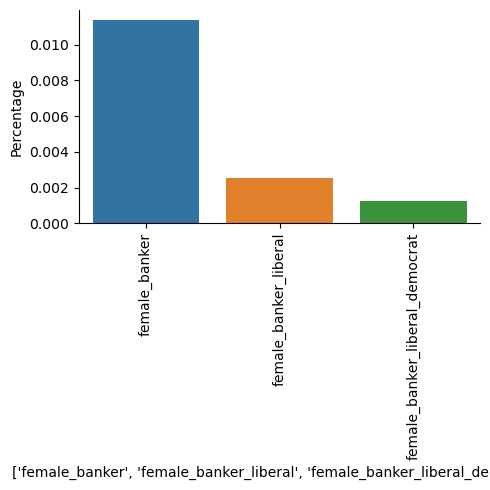

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
conditionals = ['female_banker','female_banker_liberal', 'female_banker_liberal_democrat']
df = pd.DataFrame(data=[female_banker,female_banker_liberal, female_banker_liberal_democrat], index = conditionals, columns=['percentage'])
df.columns = ['Percentage']
plt.figure(figsize=(12,18))
ax = sns.catplot(x=conditionals, y='Percentage', data=df, kind='bar')
ax.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

**Exercise:** Use `conditional` to compute the following probabilities:

* What is the probability that a respondent is liberal, given that they are a Democrat?

* What is the probability that a respondent is a Democrat, given that they are liberal?

Think carefully about the order of the arguments you pass to `conditional`.

In [90]:
conditional(liberal,given=democrat)

0.3891320002215698

In [91]:
conditional(democrat,given=liberal)

0.5206403320240125

**Exercise:** There's a [famous quote](https://quoteinvestigator.com/2014/02/24/heart-head/) about young people, old people, liberals, and conservatives that goes something like:

> If you are not a liberal at 25, you have no heart. If you are not a conservative at 35, you have no brain.

Whether you agree with this proposition or not, it suggests some probabilities we can compute as an exercise.
Rather than use the specific ages 25 and 35, let's define `young` and `old` as under 30 or over 65:

In [92]:
young = (gss['age'] < 30)
prob(young)

0.19435991073240008

In [93]:
old = (gss['age'] >= 65)
prob(old)

0.17328058429701765

For these thresholds, I chose round numbers near the 20th and 80th percentiles.  Depending on your age, you may or may not agree with these definitions of "young" and "old".

I'll define `conservative` as someone whose political views are "Conservative", "Slightly Conservative", or "Extremely Conservative".

In [94]:
conservative = (gss['polviews'] >= 5)
prob(conservative)

0.3419354838709677

Use `prob` and `conditional` to compute the following probabilities.

* What is the probability that a randomly chosen respondent is a young liberal?

* What is the probability that a young person is liberal?

* What fraction of respondents are old conservatives?

* What fraction of conservatives are old?

For each statement, think about whether it is expressing a conjunction, a conditional probability, or both.

For the conditional probabilities, be careful about the order of the arguments.
If your answer to the last question is greater than 30%, you have it backwards!

In [95]:
prob(young & liberal)

0.06579427875836884

In [96]:
conditional(young, given=liberal)

0.24034684651300675

In [97]:
prob(old & conservative)

0.06701156421180766

In [98]:
conditional(old, given=conservative)

0.19597721609113564